# Goodreads descriptive analysis

In [20]:
import gzip
import json
import numpy as np
import pandas as pd
import os
pd.options.display.float_format = '{:,}'.format

import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("whitegrid")

RANDOM = 2021

figure_path = '/home/weiss/git/thesis/doc/figures/'

DIR = '/home/weiss/rs_data/goodreads/'

In [2]:
def count_lines(file_name):
    """count number of lines in a given file"""
    print('counting file:', file_name)
    count = 0
    with gzip.open(file_name) as fin:
        for l in fin:
            count += 1
    print('done!')
    return count

In [3]:
n_book = count_lines(os.path.join(DIR, 'goodreads_books.json.gz'))
n_work = count_lines(os.path.join(DIR, 'goodreads_book_works.json.gz'))
n_author = count_lines(os.path.join(DIR, 'goodreads_book_authors.json.gz'))
n_series = count_lines(os.path.join(DIR, 'goodreads_book_series.json.gz'))

counting file: /home/weiss/rs_data/goodreads/goodreads_books.json.gz
done!
counting file: /home/weiss/rs_data/goodreads/goodreads_book_works.json.gz
done!
counting file: /home/weiss/rs_data/goodreads/goodreads_book_authors.json.gz
done!
counting file: /home/weiss/rs_data/goodreads/goodreads_book_series.json.gz
done!


In [4]:
def load_data(file_name, head = 500):
    """Load a given GZIP compressed JSON file"""
    count = 0
    data = []
    with gzip.open(file_name) as fin:
        for l in fin:
            d = json.loads(l)
            count += 1
            data.append(d)

            # break if reaches the 100th line
            if (head is not None) and (count > head):
                break
    return data

In [5]:
df_book_stats = pd.DataFrame([n_book, n_work, n_author, n_series], dtype = float,
                             columns = ['count'],
                             index = ['# book', '# work', '# author', '# series'])
print(df_book_stats)

               count
# book   2,360,655.0
# work   1,521,962.0
# author   829,529.0
# series   400,390.0


In [6]:
reviews = load_data(os.path.join(DIR, 'goodreads_reviews_dedup.json.gz'))
np.random.choice(reviews)

{'user_id': '72fb0d0087d28c832f15776b0d936598',
 'book_id': '800780',
 'review_id': '1ee42604ead1e1f86281fd866da96107',
 'rating': 4,
 'review_text': 'This book is, so many times over, a true story. Culleton does not hold back in her descriptions of the horrors these women faced. However, from true stories I\'ve heard, it is not even close to as horrible as it gets. The way native people have been treated in this country (and elsewhere) is shameful. The trickledown effect of residential schooling and prejudice has scarred our history (and is sadly, still perpetuated) and so many seem unaware. Those that say this book has an agenda... well, it certainly should. \n The author, in my opinion, successfully wrote on the issue of generational pain without making it seem as though she was "making excuses" (a common complaint I hear from prejudice types). The two little girls grew up in an unstable home, had their lives torn apart, and faced hardships throughout their lives. I particularly ide

In [7]:
# the relevant file is 'goodreads_interactions.csv'

PATH_IN = os.path.join(DIR, 'goodreads_interactions.csv')
df_interactions = pd.read_csv(PATH_IN)

In [8]:
print('=== first 5 records ===')
print(df_interactions.head())
print(f'size {df_interactions.size}')
print(f'unique users {df_interactions.user_id.unique().size}')
print(f'unique books {df_interactions.book_id.unique().size}')

=== first 5 records ===
   user_id  book_id  is_read  rating  is_reviewed
0        0      948        1       5            0
1        0      947        1       5            1
2        0      946        1       5            0
3        0      945        1       5            0
4        0      944        1       5            0
size 1143241710
unique users 876145
unique books 2360650


In [9]:
print('=== Any empty cells ===')
print(df_interactions.isnull().any())

=== Any empty cells ===
user_id        False
book_id        False
is_read        False
rating         False
is_reviewed    False
dtype: bool


In [10]:
print('=== duplicated records ===')
print(df_interactions[df_interactions.duplicated(['user_id', 'book_id'], keep=False)])

=== duplicated records ===
Empty DataFrame
Columns: [user_id, book_id, is_read, rating, is_reviewed]
Index: []


user_id
165733    119777
339532    101295
59545      82114
311008     79168
396456     77057
           ...  
694442         1
694429         1
694424         1
694422         1
828859         1
Length: 876145, dtype: int64


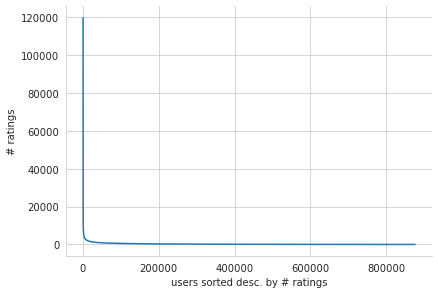

In [11]:
rating_count_by_user = df_interactions.groupby('user_id').size().sort_values(ascending=False)
print(rating_count_by_user)  # contains unrealistic users (way too many ratings)
size = rating_count_by_user.size

df = pd.DataFrame(dict(sorted_user_id=range(1,size+1), rating_counts=rating_count_by_user.values))

image = sns.relplot(data=df,
                    x="sorted_user_id",
                    y="rating_counts",
                    kind="line",
                    height=4,
                    aspect=1.5
                    )

image.set(xlabel="users sorted desc. by # ratings",
          ylabel="# ratings"
          )

image.savefig(figure_path + '/goodreads-long-tail-distribution.png', dpi=300, bbox_inches='tight')

In [12]:
# Keep entries where the user has rated more than n items and less than m items

n = 50
m = 1000

counts = df_interactions['user_id'].value_counts()
mask = (counts >= n) & (counts <= m)
print(mask.value_counts())
df_interactions = df_interactions[df_interactions['user_id'].isin(mask[mask == True].index)]

True     544597
False    331548
Name: user_id, dtype: int64


In [13]:
print('=== first 5 records ===')
print(df_interactions.head())
print(f'size {df_interactions.size}')
print(f'unique users {df_interactions.user_id.unique().size}')
print(f'unique books {df_interactions.book_id.unique().size}')

=== first 5 records ===
   user_id  book_id  is_read  rating  is_reviewed
0        0      948        1       5            0
1        0      947        1       5            1
2        0      946        1       5            0
3        0      945        1       5            0
4        0      944        1       5            0
size 674896905
unique users 544597
unique books 2116132


user_id
2191      1000
337526    1000
359669    1000
140695    1000
27283     1000
          ... 
674290      50
521231      50
582986      50
680385      50
556969      50
Length: 544597, dtype: int64
<class 'pandas.core.series.Series'>
544597


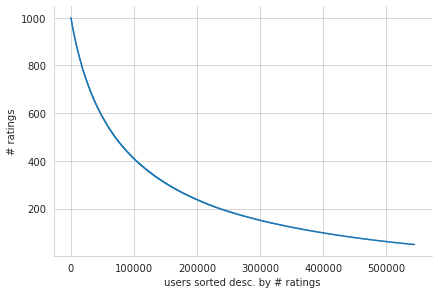

In [14]:
rating_count_by_user = df_interactions.groupby('user_id').size().sort_values(ascending=False)
print(rating_count_by_user)
print(type(rating_count_by_user))
size = rating_count_by_user.size
print(size)

df = pd.DataFrame(dict(sorted_user_id=range(1,size+1), rating_counts=rating_count_by_user.values))

image = sns.relplot(data=df,
                    x="sorted_user_id",
                    y="rating_counts",
                    kind="line",
                    height=4,
                    aspect=1.5
                    )

image.set(xlabel="users sorted desc. by # ratings",
          ylabel="# ratings"
          )

image.savefig(figure_path + '/goodreads-long-tail-distribution-cut.png', dpi=300, bbox_inches='tight')

/home/weiss/.conda/envs/GNN/lib/python3.7/site-packages/seaborn/categorical.py:3704: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/home/weiss/.conda/envs/GNN/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


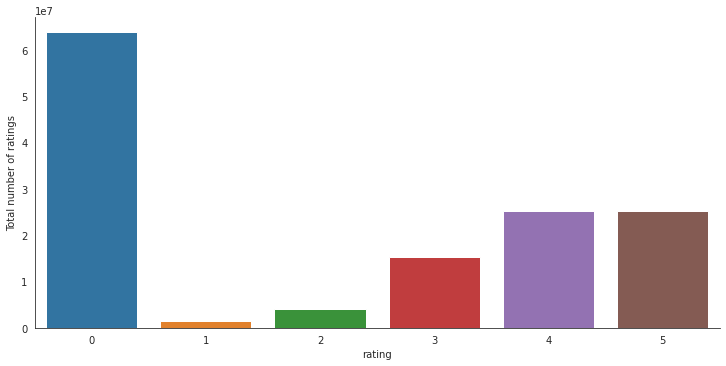

In [15]:
# rating distribution

with sns.axes_style('white'):
    g = sns.factorplot("rating", data=df_interactions, aspect=2.0,kind='count')
    g.set_ylabels("Total number of ratings")
    g.savefig(figure_path + '/goodreads-rating-distribution.png', dpi=300, bbox_inches='tight')

In [17]:
# remove ratings with value 0
df_interactions= df_interactions[df_interactions['rating'] != 0]
df_interactions


,user_id,book_id,is_read,rating,is_reviewed
0,0,948,1,5,0
1,0,947,1,5,1
2,0,946,1,5,0
3,0,945,1,5,0
4,0,944,1,5,0
...,...,...,...,...,...
228648336,876144,367428,1,3,0
228648338,876144,23847,1,4,0
228648339,876144,23950,1,3,0
228648340,876144,374106,1,5,1


/home/weiss/.conda/envs/GNN/lib/python3.7/site-packages/seaborn/categorical.py:3704: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/home/weiss/.conda/envs/GNN/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


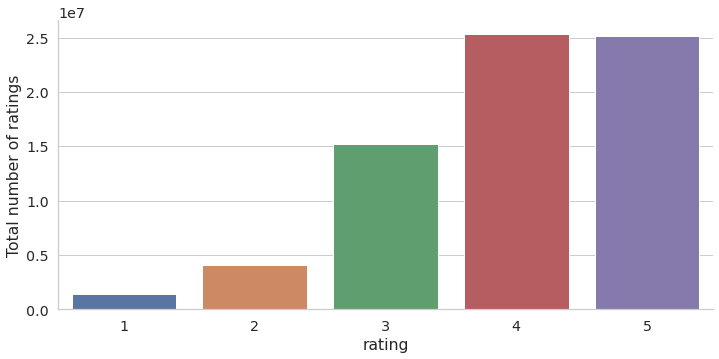

In [22]:
# rating distribution
sns.set(font_scale=1.3)
with sns.axes_style('whitegrid'):
    g = sns.factorplot("rating", data=df_interactions, aspect=2.0,kind='count')
    g.set_ylabels("Total number of ratings")
    g.savefig(figure_path + '/goodreads-rating-distribution.png', dpi=300, bbox_inches='tight')
